# Project 1 - Solving a heat equation

Notebook by: Reidar Bråthen Kristoffersen, Viktor Sandve & Trond Skaret Johansen.

## Helper functions and imports

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
import pandas as pd
from scipy.optimize import fsolve

In [ ]:
# Helper function for plotting
def add_surface(ax, x, y, U, title="", invert_x=False):
    
    # Surface given by meshgrids
    if len(x.shape) == 2:
        ax.plot_surface(x, y, U, cmap=cm.coolwarm)

    # Surface given by pointlists
    elif len(x.shape) == 1:
        ax.plot_trisurf(x, y, U, cmap=cm.coolwarm)
        ax.invert_yaxis() # Makes plots in 2) especially much nicer

    if invert_x:
        ax.invert_xaxis()

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)

# Function for comparing solutions
def plot_manufactured_experiment_result(x, y, U_num, U_anal, invert_x=False, filename=None):
    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(131, projection='3d')
    add_surface(ax1, x, y, U_num, title="Numerical solution", invert_x=invert_x)

    ax2 = fig.add_subplot(132, projection='3d')
    add_surface(ax2, x, y, U_anal, title="Manufactured solution", invert_x=invert_x)

    ax3 = fig.add_subplot(133, projection='3d')
    error = U_num-U_anal
    mag = int(np.log10(np.max(np.abs(error))))-1
    add_surface(ax3, x, y, (error)/10**(mag), title=f"Error [e{mag}]", invert_x=invert_x)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)

    plt.show()

## a) Initial experiments

Our object of study is the equation:

$$
    -\nabla\cdot(\kappa\nabla T) = f.
$$

Introducing the vectors ... as in the report, the differential operator on the left side can be rewritten as:

$$
    \nabla\cdot(\kappa\nabla T) = a\partial_{xx}u+(\vec{d}\cdot\nabla)^2u.
$$

In our first experiment we take $r=1$ so that $\vec{d}_1=(1,1)$. Using stepsize $h$ in both dimensions, this makes central difference discretisation of the directional derivatives simple:

$$
    \begin{aligned}
    \partial_{xx}u(x_i,y_j)
    &\approx\frac{U_{i+1, j}-2U_{i,j}+U_{i-1, j}}{h^2}\\
    (\vec{d}\cdot\nabla)^2u(x_i,y_j)
    &\approx\frac{U_{i+1, j+1}-2U_{i,j}+U_{i-1, j-1}}{h^2}.
    \end{aligned}
$$

Having found the stencil..........

We experiment with the following $g,h$ ...



In [ ]:
class BBVP(object): 
    def __init__(self, g = lambda x, y : 0.0*x, f =lambda x,t : 0, a=1, r=1): 
        # Boundary function
        self.g = g
        # Right hand side of equation (heat sources)
        self.f = f
        # relative strength and direction parameter
        self.a = a
        self.r = r

In [ ]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

# Matrix prepper
def A_square_grid(M, a):

    # Number of rows / columns
    block_size = M-1

    d_block = tridiag(-a, 2*a + 2, -a, M-1)
    u_block = tridiag(0, 0, -1, M-1)
    l_block = u_block.T

    # central tridiagonal matrix
    center = np.kron(np.diag(np.ones(block_size)), d_block)

    # corresponding to the northeast and southwest elements    
    upper = np.kron(np.diag(np.ones(block_size-1), 1), u_block)
    lower = np.kron(np.diag(np.ones(block_size-1), -1), l_block)

    return center + lower + upper

#print(A_square_grid(5, 3))

def BC_square_grid(h,N, g, a):

    # Init vector list
    vector = []

    # first row
    vector += [g(0,0) + a*g(0,h)] + [g(h*i,0) for i in range(1, N-1)] +[g(1-2*h, 0) + a*g(1, h) + g(1, 2*h)]

    # intermediate rows
    for i in range(2, N):
        vector += [g(0, (i-1)*h)+a*g(0, i*h)] + [0 for i in range(2, N)] + [a*g(1,i*h)+g(1, (i+1)*h)]

    # last row
    vector += [g(0, 1-2*h) + a*g(0, 1-h) + g(2*h, 1)] + [g(h*i,1) for i in range(3, N+1)] + [g(1,1) + a*g(1,1-h)]

    return np.array(vector)

#print(BC_square_grid(0.2, 4, lambda x, y : x+0.1*y, 3))


In [ ]:
# Solver
def square_solver(bbvp_object, M): 

    # This solver only works in the case r=1
    assert bbvp_object.r == 1        
    N = M-1 #number of internal points
    h = 1/M #stepsize

    # Prepare grid, matrix, boundary conditions and heat source vectors:
    x, y = np.meshgrid(np.linspace(0, 1, M+1), np.linspace(0, 1, M+1))
    A       = 1/h**2 * A_square_grid(M, bbvp_object.a)
    bc_term = 1/h**2 * BC_square_grid(h, N, bbvp_object.g, bbvp_object.a)
    f_term  = bbvp_object.f(x[1:-1, 1:-1], y[1:-1, 1:-1]).flatten()

    # Evaluate the boundary. Slice out the internal points and flatten
    U = bbvp_object.g(x, y)
    U_internal = U[1:-1, 1:-1].flatten()

    # Solve the system
    U_internal = np.linalg.solve(A, bc_term + f_term)

    # Unflatten and insert the solution to U
    U[1:-1, 1:-1] = U_internal.reshape(N, N)

    return x, y, U

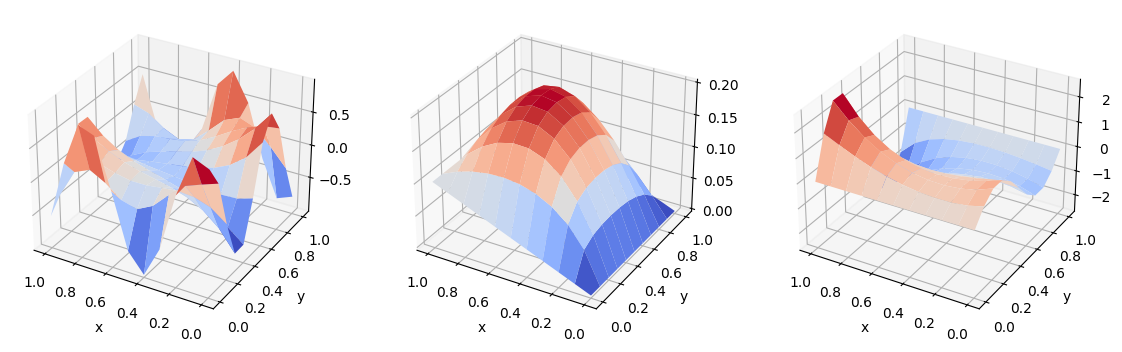

In [ ]:
### First tests
bbvps = [BBVP(g=lambda x, y : np.sin(9*x+1)*np.cos(9*y),   f=lambda x,y : 0*x, a=3, r=1),
         BBVP(g=lambda x, y : 0.1*x,                       f=lambda x,y : 5+0*x, a=3, r=1),
         BBVP(g=lambda x, y : np.exp(x)*np.sin(2*np.pi*y), f=lambda x,y : 0*x, a=3, r=1)]

fig = plt.figure(figsize=(14,7))
for i in range(len(bbvps)):
    ax = fig.add_subplot(1,len(bbvps),i+1, projection='3d')
    add_surface(ax, *square_solver(bbvps[i], 10), invert_x=True)
plt.show()

## c) Convergence rate

Here we

* Test the scheme
* Check convergence rate
* Make tables of errors and convergence rates
* Plot the solution and log-log plots of the errors in some cases

We manufacture three solutions

#### 1. $    T_1(x,y) = \sin(\pi x)\cos(\pi y)$

Which gives 

$$
    -f_1=\nabla\cdot(\kappa\nabla T_1) = (a+1)\partial_x^2T_1+2r\partial_x\partial_yT_1+r^2\partial_y^2 T_1= -(a+1)\pi^2T_1(x,y)-2r\pi^2T_1(y,x)-r^2\pi^2 T_1(x,y).
$$

#### 2. $    T_2(x,y) = x^3y^4$

Which gives 

$$
    -f_2=(a+1)6xy^4+2r12x^2y^3+r^212x^3y^2.
$$

#### 3. $T_3(x,y) = \sin(\pi x)\sin(\pi y).$

Which gives

$$
    -f_3 = -\pi^2((a+1+r^2)T_3(x,y)-2r\cos(\pi x)\cos(\pi y)).
$$

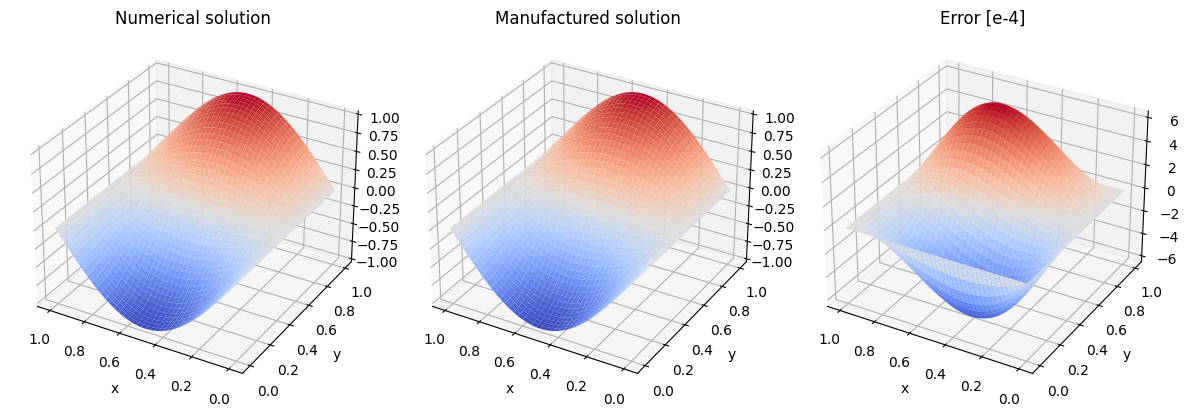

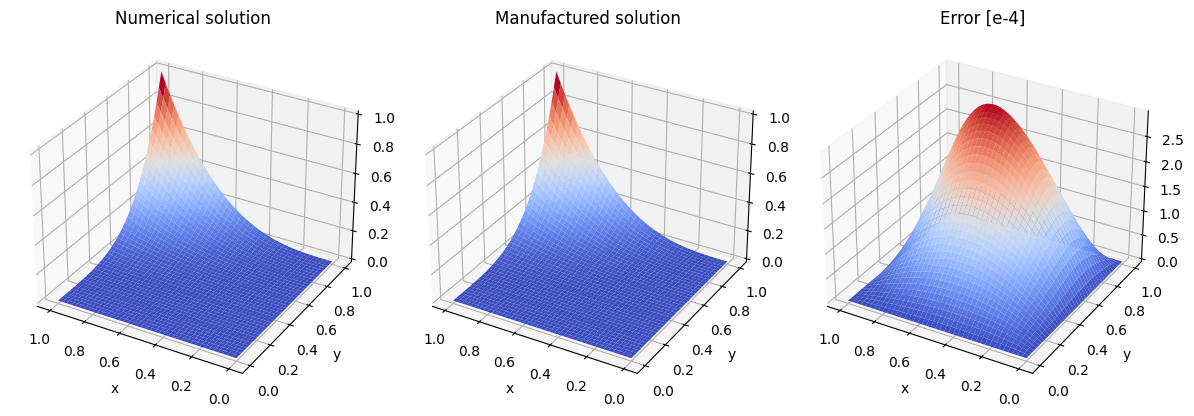

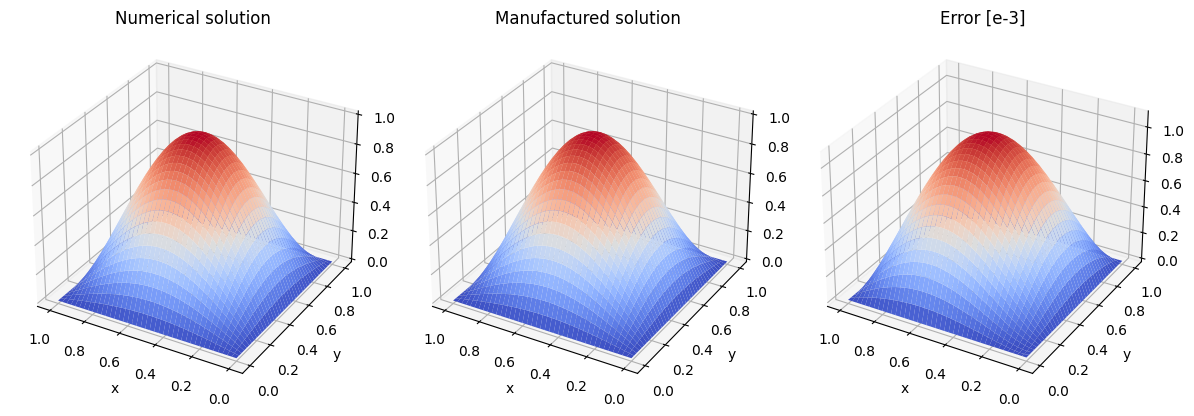

In [ ]:
 # Define manufactured solutions and their corresponding f
def T1(x,y):
    return - (np.sin(np.pi*x) * np.cos(np.pi*y))
def f1(x,y, a=3, r=1):
    return  (np.pi**2 * ((a+1+r**2)*T1(x,y) + 2*r*T1(y,x)))

def T2(x,y):
    return x**3*y**4
def f2(x,y, a=3, r=1):
    return -(a+1)*6*x*y**4 - 24*r*x**2*y**3 - 12*r**2*x**3*y**2

def T3(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)
def f3(x,y,a,r):
    return np.pi**2*((a+1+r**2)*T3(x,y) - 2*r*np.cos(np.pi*x)*np.cos(np.pi*y))

def manufactured_experiment(T_man, f_man, solver=square_solver, a=3, r=1, invert_x=False, M=40):
    bbvp = BBVP(T_man, lambda x, y : f_man(x, y, a, r), a, r)
    x, y, U_num = solver(bbvp, M)
    U_anal = T_man(x,y)
    plot_manufactured_experiment_result(x, y, U_num, U_anal, invert_x=invert_x)
  
manufactured_experiment(T1, f1, invert_x=True)
manufactured_experiment(T2, f2, invert_x=True)
manufactured_experiment(T3, f3, invert_x=True)

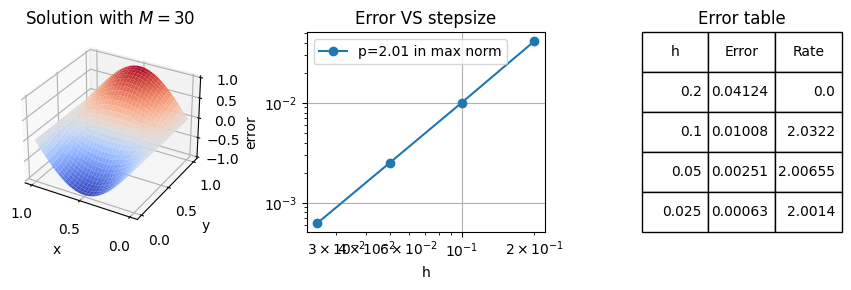

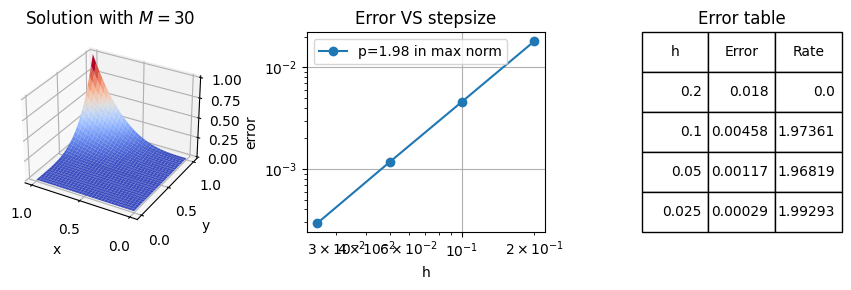

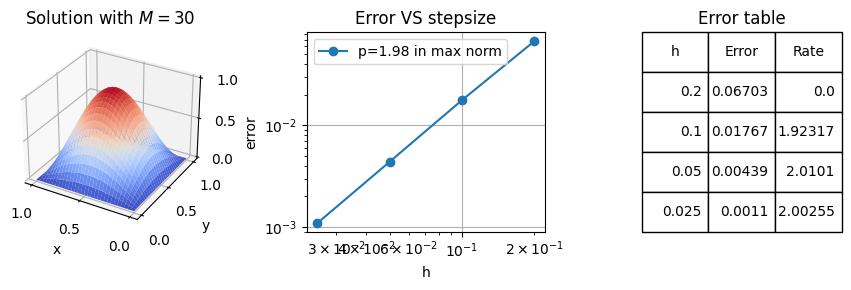

In [ ]:
# Function operating a convergence study
def convergence(bvp, u_exact, solver=square_solver): 

    P = 4
    Hconv = np.zeros(P)
    Emax = np.zeros(P)
    M = 5
    for p in range(P):
        x,y, U = solver(bvp, M)
        Emax[p] = np.max(np.abs(u_exact(x,y) - U))
        Hconv[p] = y[1,0]-y[0,0]
        M = 2*M

    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax
        
def convergence_experiment(T_man, f_man, solver=square_solver, a=3, r=1):
    bbvp = BBVP(T_man, lambda x, y : f_man(x, y, a, r), a, r)
    H, EM, pM = convergence(bbvp, T_man, solver = solver)
    
    #Plot of the convergence plot
    Rate=np.zeros(np.size(EM))
    Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
    pd.options.display.float_format = '{:.5f}'.format
    df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 

    return df, H, EM, pM

def plot_convergence_experiment_result(f_man, T_man, filename=None, solver=square_solver, a=3, r=1, invert_x=True, show_error=False, M=30):

    if show_error:
        fig = plt.figure(figsize=(12,3))
        cols = 4
    else:
        fig = plt.figure(figsize=(9,3))
        cols = 3

    # Add surface
    ax1 = fig.add_subplot(1, cols, 1, projection='3d')
    bbvp = BBVP(T_man, lambda x, y : f_man(x, y, a, r), a, r)
    x, y, U = solver(bbvp, M)
    add_surface(ax1, x, y, U, title=rf"Solution with $M=${M}", invert_x=invert_x)

    # Add error for the surface
    if show_error:
        ax11 = fig.add_subplot(1, cols, 2, projection='3d')
        error = U - T_man(x,y)
        mag = int(np.log10(np.max(np.abs(error))))-1
        add_surface(ax11, x, y, (error)/10**(mag), title=f"Error [e{mag}]", invert_x=invert_x)

    # Add loglog and table
    df, H, EM, pM = convergence_experiment(T_man, f_man, solver=solver, a=a, r=r)

    ax2 = fig.add_subplot(1, cols, 2+int(show_error))
    ax2.loglog(H,EM,'o-', label='p={:.2f} in max norm'.format(pM))
    ax2.grid('on')
    ax2.set_xlabel('h')
    ax2.set_ylabel('error')
    ax2.set_title("Error VS stepsize")
    ax2.legend()

    df = df.round(decimals=5)
    ax3 = fig.add_subplot(1, cols, 3+int(show_error), projection='3d')
    table = ax3.table(cellText=df.values, colLabels=df.columns, loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax3.set_title("Error table")
    ax3.axis('off')

    # Tight, save and show
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

plot_convergence_experiment_result(f1, T1, filename="error_1c_1.png")
plot_convergence_experiment_result(f2, T2, filename="error_1c_2.png")
plot_convergence_experiment_result(f3, T3, filename="error_1c_3.png")

## d) Irrational $r$

We now use step sizes $h=\frac{1}{M}, k=|r|h$ in the $x$ and $y$-directions. 

We miss the upper boundary, which can be resolved by using a function defined outside or by projecting. 

In [ ]:
# Matrix prepper
def A_rectangular_grid(M, N, a):

    # Number of rows / columns
    block_size = M-1
    num_blocks = N-1

    d_block = tridiag(-a, 2*a + 2, -a, M-1)
    u_block = tridiag(0, 0, -1, M-1)
    l_block = u_block.T

    # central tridiagonal matrix
    center = np.kron(np.diag(np.ones(num_blocks)), d_block)

    # corresponding to the northeast and southwest elements    
    upper = np.kron(np.diag(np.ones(num_blocks-1), 1), u_block)
    lower = np.kron(np.diag(np.ones(num_blocks-1), -1), l_block)

    return center + lower + upper

#print(A_rectangular_grid(3,6, 3))

def BC_rectangular_grid(h, k, N, I, g, a, project):

    y_max = k*N
    # Init vector list
    vector = []

    # first row
    vector += [g(0,0) + a*g(0,k)] + [g(h*i,0) for i in range(1, I-1)] +[g(1-2*h, 0) + a*g(1, k) + g(1, 2*k)]

    # intermediate rows
    for i in range(2, N-1):
        vector += [g(0, (i-1)*k)+a*g(0, i*k)] + [0 for i in range(2, I)] + [a*g(1,i*k)+g(1, (i+1)*k)]

    # last row
    if project:
        vector += [g(0, y_max-2*k) + a*g(0, y_max-k) + g(2*h, 1)] + [g(h*i,1) for i in range(3, I+1)] + [g(1,1) + a*g(1,y_max-k)]
    else:
        vector += [g(0, y_max-2*k) + a*g(0, y_max-k) + g(2*h, y_max)] + [g(h*i,y_max) for i in range(3, I+1)] + [g(1,y_max) + a*g(1,y_max-k)]

    return np.array(vector)

#print(BC_square_grid(0.2, 4, lambda x, y : x+0.1*y, 3))

In [ ]:
# Solver
def rectangular_solver(bbvp_object, M, project=False): 
    
    h = 1/M #stepsize in x
    k = abs(bbvp_object.r)*h #stepsize in y
    N = int(np.ceil(1/k)) #number of steps in y direction
    I = M-1 #number of internal points per row
   
    # Prepare grid, matrix, boundary conditions and heat source vectors:
    # linspace more robust that arange (always get right number)
    x, y = np.meshgrid(np.linspace(0, 1, num=M+1), np.linspace(0, N*k, num=N+1))
    A       = 1/h**2 * A_rectangular_grid(M, N, bbvp_object.a)
    bc_term = 1/h**2 * BC_rectangular_grid(h, k, N, I, bbvp_object.g, bbvp_object.a, project)
    f_term  = bbvp_object.f(x[1:-1, 1:-1], y[1:-1, 1:-1]).flatten()

    # Project at y=1. BC taken care of above. Now move points to compare solutions
    # In problem 2) we instead drop the points for comparing
    # Either is fine as the error on the bnd'ry is 0 anyways. 
    if project:
        y[-1, :] = 1

    # Evaluate the boundary. Slice out the internal points and flatten
    U = bbvp_object.g(x, y)
    U_internal = U[1:-1, 1:-1].flatten()
    
    # Solve the system 
    U_internal = np.linalg.solve(A, bc_term + f_term)

    # Unflatten and insert the solution to U
    U[1:-1, 1:-1] = U_internal.reshape(N-1, I)   #bytta om på x og y et sted??? her er hvertfall y koord før x

    return x, y, U

def rectangular_solver_project(bbvp_object, M):
    return rectangular_solver(bbvp_object, M, project=True)

## Test på at y ser riktig ut
#bbvp = BBVP(g=T1,   f=f1,    a=3, r=np.pi)
#x, y, U = rectangular_solver_project(bbvp, 10)
#print(y)

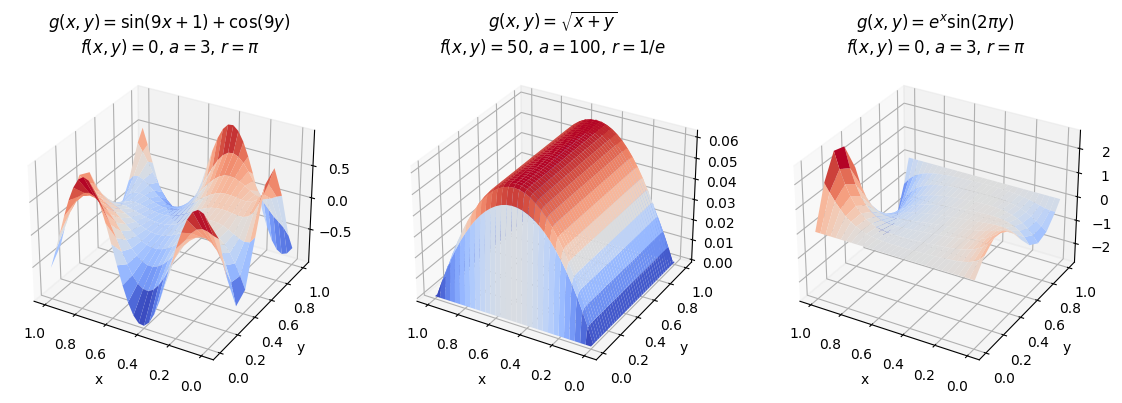

In [ ]:
### First tests
bbvps = [BBVP(g=lambda x, y : np.sin(9*x+1)*np.cos(9*y),   f=lambda x,y : 0*x,    a=3, r=np.pi),
         BBVP(g=lambda x, y : 0*np.sqrt(x+y),              f=lambda x,y : 50+0*x, a=100, r=1/np.e),
         BBVP(g=lambda x, y : np.exp(x)*np.sin(2*np.pi*y), f=lambda x,y : 0*x,    a=3, r=np.pi)]

titles = [r"$g(x,y)=\sin(9x+1)+\cos(9y)$" + "\n" + rf"$f(x,y)=0$, $a=${bbvps[0].a}, $r=\pi$", 
          r"$g(x,y)=\sqrt{x+y}$" + "\n" + rf"$f(x,y)=50$, $a=${bbvps[1].a}, $r=1/e$", 
          r"$g(x,y)=e^{x}\sin(2\pi y)$" + "\n" + rf"$f(x,y)=0$, $a=${bbvps[2].a}, $r=\pi$"]

fig = plt.figure(figsize=(14,7))
for i in range(len(bbvps)):
    ax = fig.add_subplot(1,len(bbvps),i+1, projection='3d')
    add_surface(ax, *rectangular_solver_project(bbvps[i], 30), invert_x=True, title=titles[i])
plt.show()

### Convergence

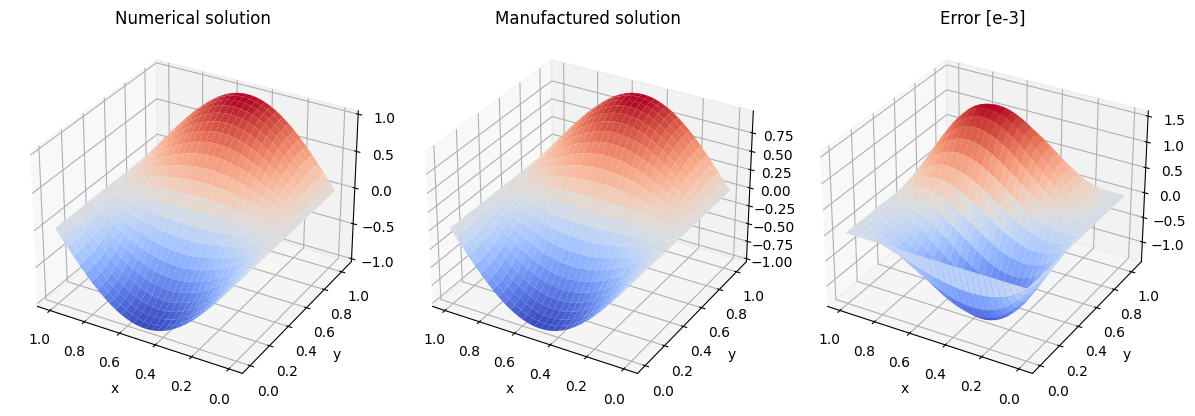

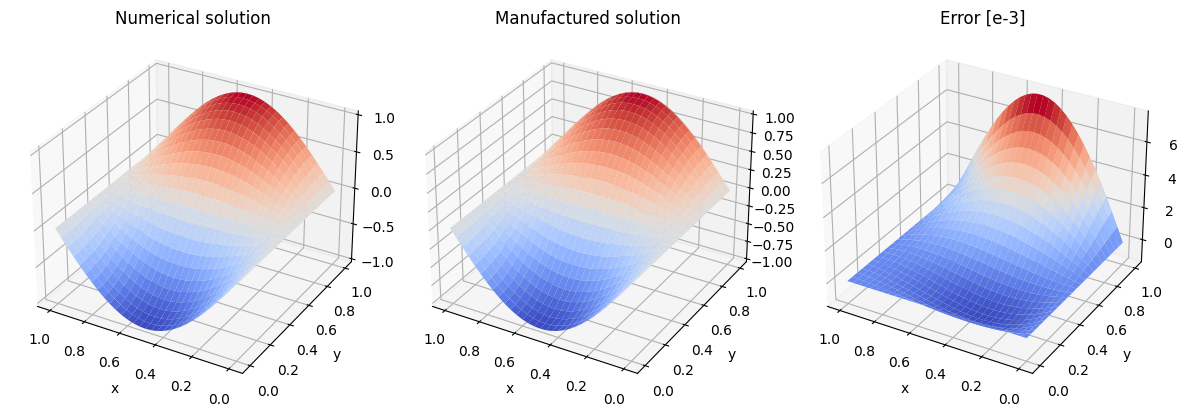

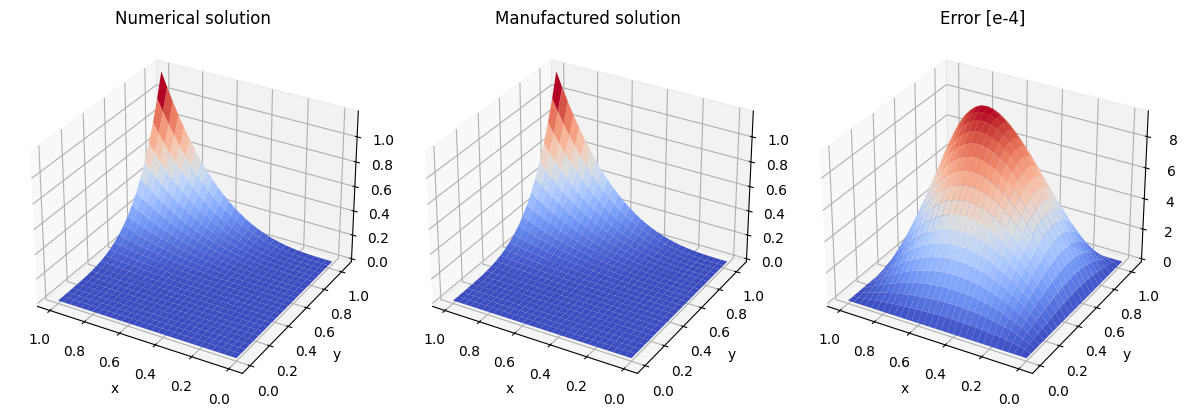

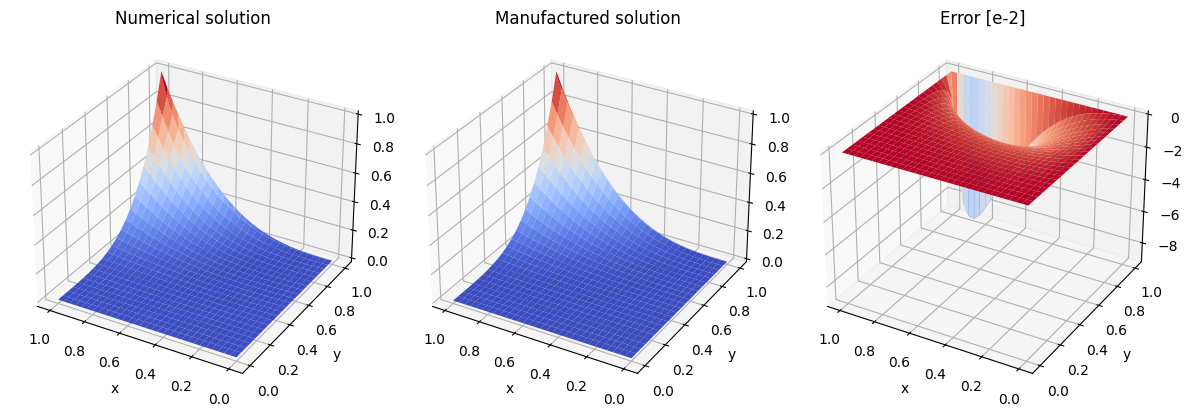

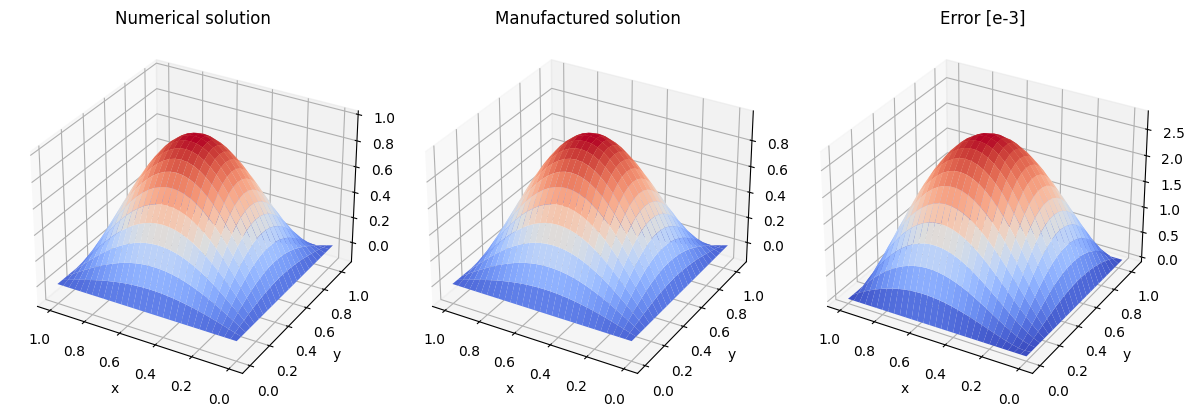

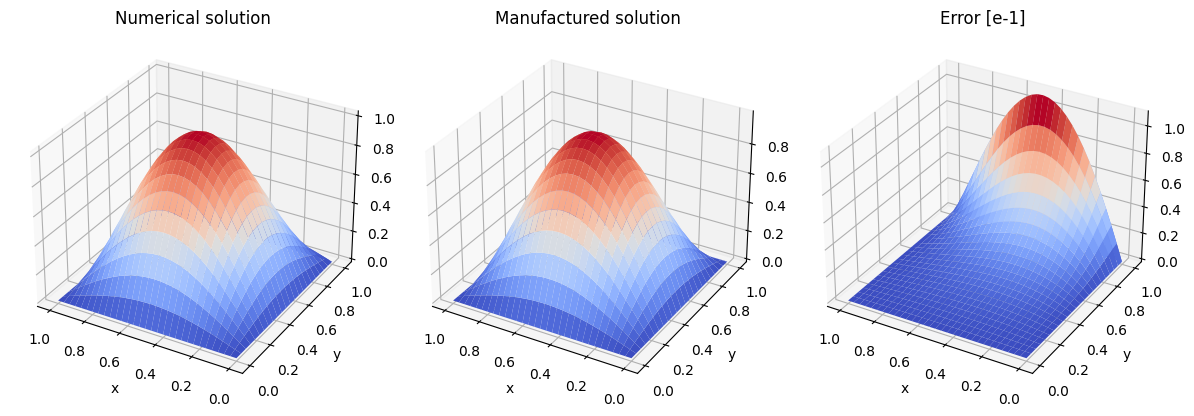

In [ ]:
### Skjønner ikke at vi ikke får trøbbel med error på project?
### Kan det være fordi den deriverte i y retning er 0 på boundarien, så O(h) --> O(h^2) for T1 ?
manufactured_experiment(T1, f1, solver=rectangular_solver,         a=3, r=0.5*np.e, invert_x=True, M=30)
manufactured_experiment(T1, f1, solver=rectangular_solver_project, a=3, r=0.5*np.e, invert_x=True, M=30)

manufactured_experiment(T2, f2, solver=rectangular_solver,         a=3, r=0.5*np.e, invert_x=True, M=30)
manufactured_experiment(T2, f2, solver=rectangular_solver_project, a=3, r=0.5*np.e, invert_x=True, M=30)

manufactured_experiment(T3, f3, solver=rectangular_solver,         a=3, r=0.5*np.e, invert_x=True, M=30)
manufactured_experiment(T3, f3, solver=rectangular_solver_project, a=3, r=0.5*np.e, invert_x=True, M=30)

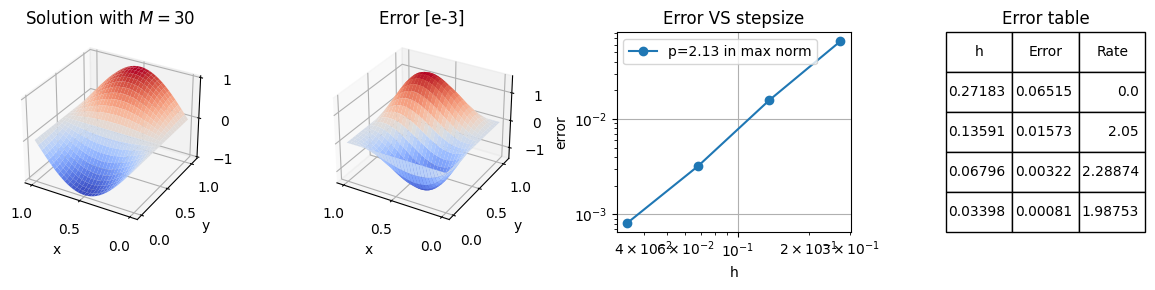

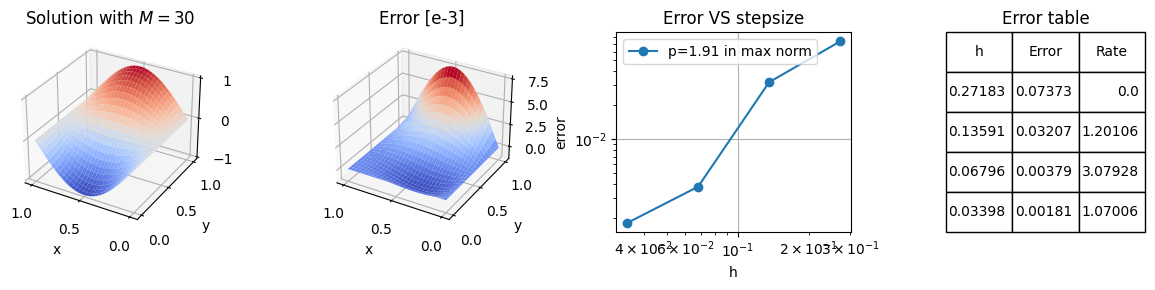

In [ ]:
plot_convergence_experiment_result(f1, T1, r=0.5*np.e, filename="error_1d_1_extend.png", 
                                   solver=rectangular_solver, invert_x=True, show_error=True)
plot_convergence_experiment_result(f1, T1, r=0.5*np.e, filename="error_1d_1_project.png", 
                                   solver=rectangular_solver_project, invert_x=True, show_error=True)

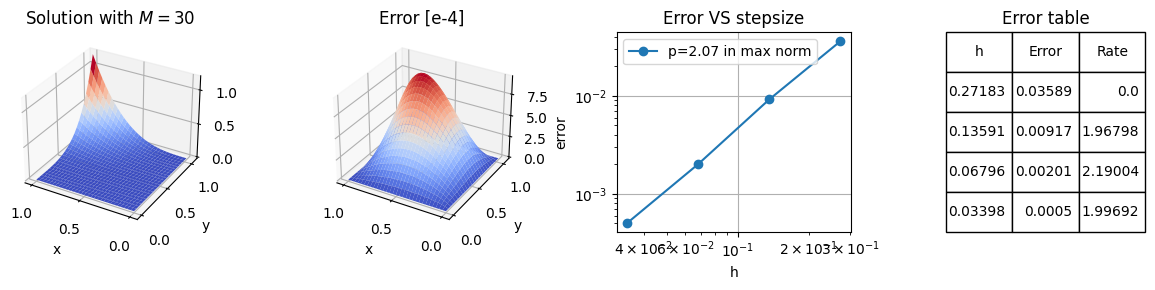

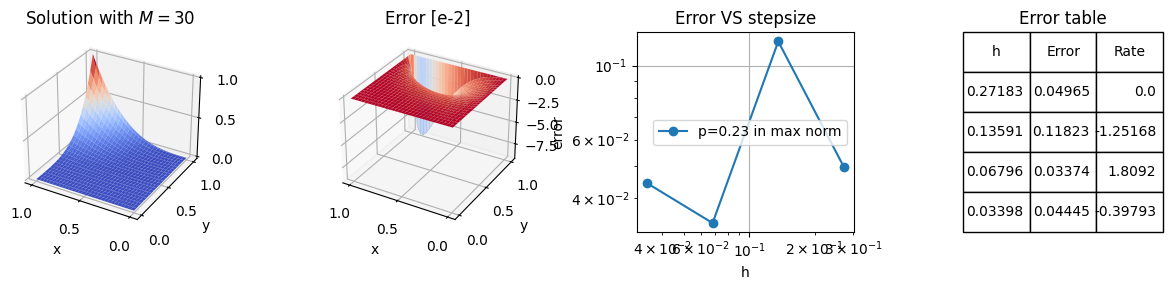

In [ ]:
plot_convergence_experiment_result(f2, T2, r=0.5*np.e, filename="error_1d_2_extend.png", 
                                   solver=rectangular_solver, invert_x=True, show_error=True)
plot_convergence_experiment_result(f2, T2, r=0.5*np.e, filename="error_1d_2_project.png", 
                                   solver=rectangular_solver_project, invert_x=True, show_error=True)

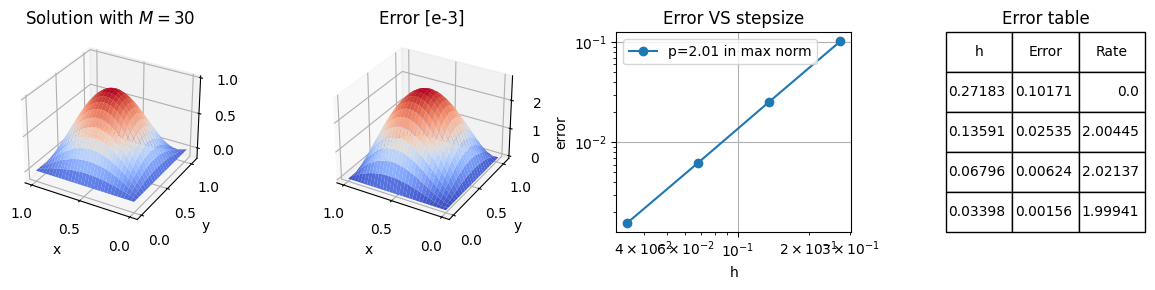

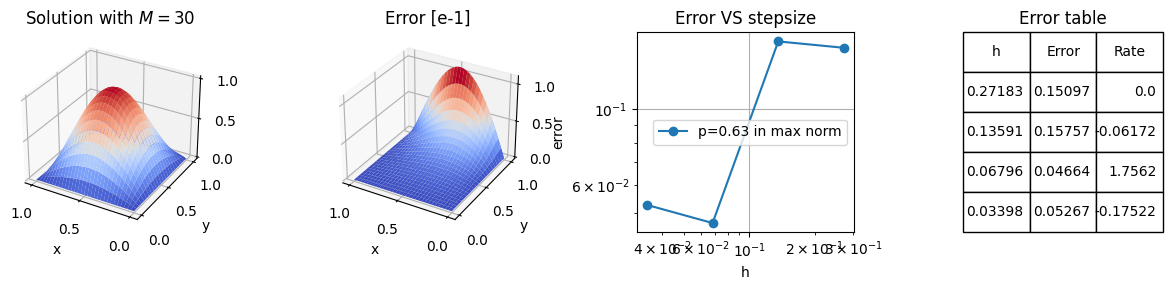

In [ ]:
plot_convergence_experiment_result(f3, T3, r=0.5*np.e, filename="error_1d_3_extend.png", 
                                   solver=rectangular_solver, invert_x=True, show_error=True)
plot_convergence_experiment_result(f3, T3, r=0.5*np.e, filename="error_1d_3_project.png", 
                                   solver=rectangular_solver_project, invert_x=True, show_error=True)

The (second?) plot shows a significant increase in the error towards the fattened boundary at $y=1$. This is somewhat as expected, since we are approximating the boundary conditions. From the third plot we also find that the error does not seem to strictly decrease with the stepsize $h$. We suspect this is due to how much the boundary is fattened, or in other words, by how much the grid misses the upper y-boundary. If this is the case chosing a stepsize such that the upper boundary of the grid is close to 1 would be beneficial, but this would require further numerical analysis outside the scope of this "report/article/experiment. 

## Problem 2)

We now consider isotropic materials, and our equation becomes

$$
    \partial_{xx}T+\partial_{yy}T = f \textrm{ on } \Omega 
$$

We consider the irregular domain described in the report, being the subset of the unit square under the graph of  $h(x) = 1/2(\cos(\pi x) + 1)$. We explore two methods for handling the irregular grid. 

(i) Modify discretisation near boundary


(ii) Fatten the boundary

We let the boundary $\partial \mathbb{G}$ consist of the grid points on the axis and the grid points closest to but outside the graph. 

Our test problems are defined on all of $\mathbb{R}^2$, so we may simply use the function as its own extension on the fattened boundary. 

We also implement the projection

### Exploring the new domain and finding projection

In [ ]:
# The boundary function and its inverse. These are global!
def H(x):
    return 1/2 * (np.cos(np.pi*x) + 1)
def dH(x):
    return -np.pi/2*np.sin(np.pi*x)
def H_inv(x):
    return 1/np.pi * np.arccos(2*x-1)


def find_points_fattened_boundary(M):

    # Points in [0,1]^2 with spacing h=1/M
    h = 1/M
    x_p = np.linspace(0, 1, M+1)
    points = np.array([np.array([x,y]) for y in x_p for x in x_p])

    # Partition (and drop external)
    boundary_points = []
    internal_points = []
    for p in points:
        # Axis
        if p[0] == 0 or p[1] == 0:
            boundary_points.append(p)
        # Under curve
        elif p[1] < H(p[0]):
            internal_points.append(p)
        # Just outside curve
        elif (np.abs(H(p[0]) - p[1]) <= h) or (np.abs(p[0] - H_inv(p[1])) <= h):
            boundary_points.append(p)   
   
    return np.array(internal_points), np.array(boundary_points)

def find_points_modified_boundary(M):

    h = 1/M

    internal_points, bp = find_points_fattened_boundary(M)
    boundary_points = []

    # When a fat boundary point is found we make sure to project it
    # both to the left and down, whilst ensuring we dont get duplicates
    # the duplicates are simply removed later with list(set())
    for p in bp:
        if p[0] == 0 or p[1] == 0:
            boundary_points.append(p)
        else:
            boundary_points.append(np.array([p[0], H(p[0])]))   
            boundary_points.append(np.array([H_inv(p[1]), p[1]]))   

    # Filter duplicates
    boundary_points = np.unique(np.array(boundary_points), axis=0)

    # Remove useless points (sometimes we get points with one coordinate < h)
    boundary_points = boundary_points[np.all(boundary_points >= h, axis=1) + np.any(boundary_points == 0, axis=1)]

    return internal_points, boundary_points

def plot_grid_and_boundary(M, find_points_func, ax):

    # Plot the boundary
    x_vals = np.linspace(0, 1, 100)
    ax.plot(x_vals, 0*x_vals, c="r")
    ax.plot(0*x_vals, x_vals, c="r")
    ax.plot(x_vals, H(x_vals), c="r", label=r"$\partial\Omega$")

    # Plot the points including fattened boundary and outside points
    internal_points, boundary_points = find_points_func(M)           
    ax.plot(*zip(*internal_points), "*", color="blue", label=r"$\mathbb{G}$")
    ax.plot(*zip(*boundary_points), "*", color="red", label=r"$\partial\mathbb{G}$")

    # Show the plot
    ax.legend(loc="upper right")
    if find_points_func == find_points_fattened_boundary:
        ax.set_title(f"Fattened grid points, M={M}")
    elif find_points_func == find_points_modified_boundary:
        ax.set_title(f"Modified grid points, M={M}")

/shared-libs/python3.9/py/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


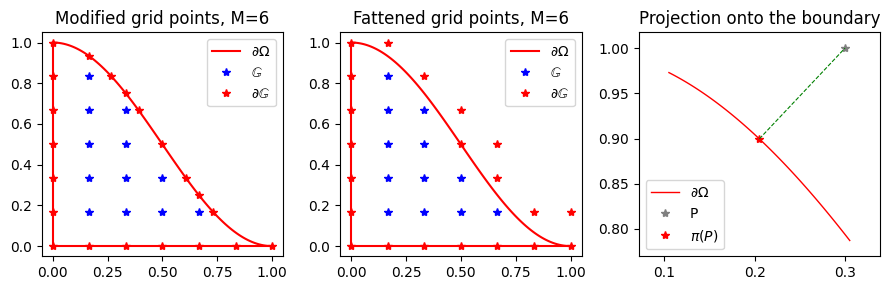

In [ ]:
def get_projection_equation(px,py):
    """
        The equation to find the 0 of. Obtained by setting the derivative of the square distance to zero
    """
    return lambda x : (x-px) + (H(x)-py)*dH(x)

def projection(px, py):
    """
        Computes the nearest x on the curve (x, h(x)) given point p=(px, py)
    """
    return fsolve(get_projection_equation(px,py), 0.5)

def plot_curve_and_projection(px, py, ax):
    x = projection(px, py)
    x_vals = np.linspace(x-0.1, x+0.1, 100)
    ax.plot(x_vals, H(x_vals), label=r"$\partial\Omega$", color="red", linewidth=1)
    ax.plot(px, py,  "*", color="grey", label="P")
    ax.plot(x, H(x), "*", color="red", label=r"$\pi(P)$")
    ax.plot([x, px], [H(x), py], "--g", linewidth=0.8)
    ax.axis("equal")
    ax.legend()
    ax.set_title(r"Projection onto the boundary")

fig, ax = plt.subplots(1,3, figsize=(9,3))
plot_grid_and_boundary(6, find_points_modified_boundary, ax[0])
plot_grid_and_boundary(6, find_points_fattened_boundary, ax[1])
plot_curve_and_projection(0.3,1, ax[2])
plt.tight_layout()
plt.savefig("grid.png")
plt.show()

### Fattening the boundary


In [ ]:
def fattened_boundary_tools(h, f, g, ip, tol=1e-10, project=False):
    """
    h: stepsize
    f: right hand side function
    g: boundary fuction, to be evaluated on fattened boundary points
    ip: internal points
    """
    # Construct the matrix and bc term
    N = ip.shape[0]
    A = []
    bc_term = np.zeros(N)

    # For each point we add the correct row to A and entry to bc_term
    for i, p in enumerate(ip):

        # Initialise and add Contribution on the diagonal
        row = np.zeros(N)
        row[i] = -4

        # Contribution from N, S, E, W
        directions = [np.array([0, h]), np.array([0, -h]), np.array([h, 0]), np.array([-h, 0])]
        for d in directions:

            # Find index of point in direction. 
            index = np.where(np.all(np.isclose(ip, p+d, atol=tol), axis=1))[0]
            if len(index) == 1: # If it exists, add contribution to A
                row[index] = 1
            else:               # if not; the point lies on boundary and is evaluated for bc_term
                if project and  not ((p+d)[0] == 0 or (p+d)[1] == 0):
                    x_project = projection((p+d)[0], (p+d)[1])
                    bc_term[i] += g(x_project, H(x_project))
                else:
                    bc_term[i] += g((p+d)[0], (p+d)[1])

        A.append(row)

    # f evaluated at internal points
    f_term = [f(p[0], p[1]) for p in ip]

    return 1/h**2*np.array(A), -1/h**2*np.array(bc_term), np.array(f_term)

def fattened_boundary_tools_project(h, f, g, ip, tol=1e-10):
    return fattened_boundary_tools(h, f, g, ip, tol=1e-10, project=True)

# Test (verified with figure of points)
M = 6
ip, bp = find_points_fattened_boundary(M)
A, bc, f_t = fattened_boundary_tools(1/M, lambda x, y : x+y, lambda x, y : x+y, ip)
print(A)
print(bc)
print(f_t)

[[-144.   36.    0.    0.   36.    0.    0.    0.    0.    0.    0.    0.]
 [  36. -144.   36.    0.    0.   36.    0.    0.    0.    0.    0.    0.]
 [   0.   36. -144.   36.    0.    0.   36.    0.    0.    0.    0.    0.]
 [   0.    0.   36. -144.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  36.    0.    0.    0. -144.   36.    0.   36.    0.    0.    0.    0.]
 [   0.   36.    0.    0.   36. -144.   36.    0.   36.    0.    0.    0.]
 [   0.    0.   36.    0.    0.   36. -144.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.   36.    0.    0. -144.   36.   36.    0.    0.]
 [   0.    0.    0.    0.    0.   36.    0.   36. -144.    0.   36.    0.]
 [   0.    0.    0.    0.    0.    0.    0.   36.    0. -144.   36.   36.]
 [   0.    0.    0.    0.    0.    0.    0.    0.   36.   36. -144.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.   36.    0. -144.]]
[ -12.  -12.  -18.  -96.  -12.   -0.  -72.  -18.  -36.  -24.  -84. -114.]
[0.33333333 0.5        0.

In [ ]:
def irregular_boundary_solver(bbvp_object, tools_function, M, remove_external=False): 
    
    # Find the points we need
    ip, bp = find_points_modified_boundary(M)

    # Prepare grid, matrix, boundary conditions and heat source vectors:
    A, bc_term, f_term = tools_function(1/M, bbvp_object.f, bbvp_object.g, ip)

    # Solve the system 
    U_internal = np.linalg.solve(A, bc_term + f_term)

    # Evaluate the boundary
    U_boundary = np.array([bbvp_object.g(p[0], p[1]) for p in bp])

    # Remove points outside the irregular boundary
    if remove_external:
        condition = ~((bp[:, 0] > 0) & (bp[:, 1] > 0)) & (bp[:, 1] < H(bp[:,0]))
        U_boundary = U_boundary[condition]
        bp = bp[condition]

    # Reshape a bit
    points = np.concatenate([ip, bp])
    x = points[:, 0]
    y = points[:, 1]
    U = np.concatenate([U_internal, U_boundary])

    return x, y, U

In [ ]:
# Convergence test, define manufactured solutions and their corresponding f
def T1_irregular(x,y):
    return np.sin(np.pi*x) * np.cos(np.pi*y)
def f1_irregular(x,y):
    return - 2*np.pi**2 * T1_irregular(x,y)

def T2_irregular(x,y):
    return 100*(x**3*y**4)
def f2_irregular(x,y):
    return 100*(6*x*y**4 + 12*x**3*y**2)

def manufactured_experiment_irregular(T_man, f_man, tool_function, M=30, remove_external=False):
    bbvp = BBVP(T_man, f_man)
    x, y, U_num = irregular_boundary_solver(bbvp, tool_function, M, remove_external=remove_external)
    U_anal = T_man(x,y)
    plot_manufactured_experiment_result(x, y, U_num, U_anal)

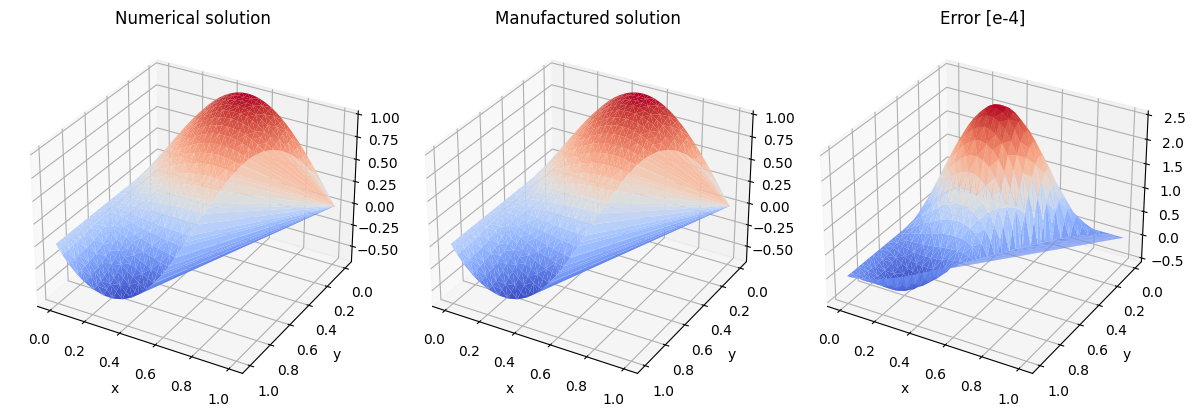

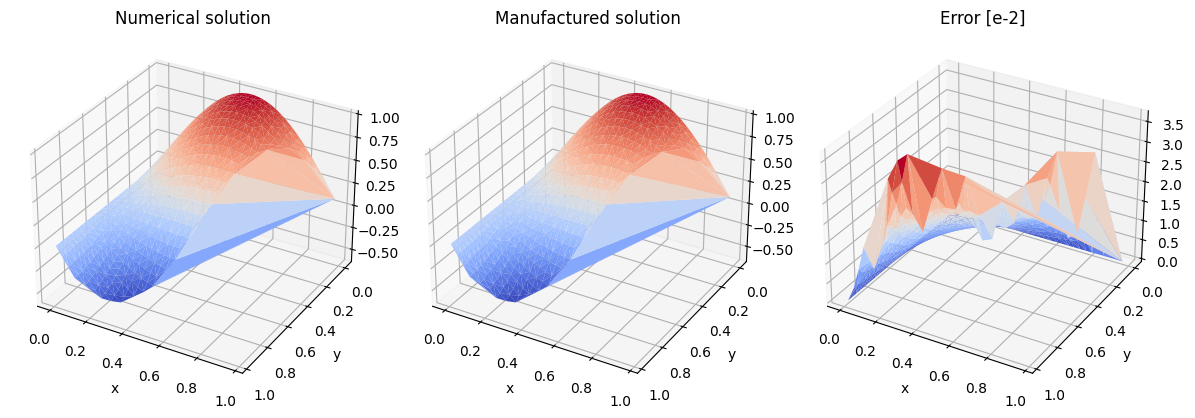

In [ ]:
manufactured_experiment_irregular(T1_irregular, f1_irregular, tool_function=fattened_boundary_tools)
manufactured_experiment_irregular(T1_irregular, f1_irregular, tool_function=fattened_boundary_tools_project, remove_external=True)

### Modifying the boundary

This time we must take values on the boundary instead

In [ ]:
def modified_boundary_tools(h, f, g, ip, tol=1e-8):
    """
    h: stepsize
    f: right hand side function
    g: boundary fuction, to be evaluated on fattened boundary points
    ip: internal points
    """
    # Construct the matrix and bc term
    N = ip.shape[0]
    A = []
    bc_term = np.zeros(N)

    # For each point we add the correct row to A and entry to bc_term
    for i, p in enumerate(ip):

        # Initialise
        row = np.zeros(N)

        # Find indeces
        n_idx = np.where(np.all(np.isclose(ip, p + np.array([0, h]),  atol=tol), axis=1))[0]
        s_idx = np.where(np.all(np.isclose(ip, p + np.array([0, -h]), atol=tol), axis=1))[0]
        e_idx = np.where(np.all(np.isclose(ip, p + np.array([h, 0]),  atol=tol), axis=1))[0]
        w_idx = np.where(np.all(np.isclose(ip, p + np.array([-h, 0]), atol=tol), axis=1))[0]
        
        # Handle each direction
        s, t = 1, 1
        if len(n_idx) == 0:
            point = np.array([p[0], H(p[0])])
            t = np.abs(point[1]-p[1]) / h
            bc_term[i] += 2/(t*(t+1))*g(point[0], point[1]) # Evaluate in boundary point
        else:
            row[n_idx] = 1
        if len(s_idx) == 0:
            bc_term[i] += 2/(1+t)*g(p[0], p[1]-h) # Evaluate one down
        else:
            row[s_idx] = 2/(1+t)

        if len(e_idx) == 0:
            point = np.array([H_inv(p[1]), p[1]])
            s = np.abs(point[0]-p[0]) / h
            bc_term[i] += 2/(s*(s+1))*g(point[0], point[1]) # Evaluate in boundary point
        else:
            row[e_idx] = 1
        if len(w_idx) == 0:
            bc_term[i] += 2/(1+s)*g(p[0]-h, p[1]) # Evaluate one to the left
        else:
            row[w_idx] = 2/(1+s)

        # Handle diagonal
        row[i] = -2/s-2/t

        # Add result
        A.append(row)

    # f evaluated at internal points
    f_term = [f(p[0], p[1]) for p in ip]

    return np.array(A), -np.array(bc_term), h**2*np.array(f_term)

# Test (verified with figure of points)
M = 6
ip, bp = find_points_modified_boundary(M)
A, bc, f_t = modified_boundary_tools(1/M, lambda x, y : x+y, lambda x, y : x+y, ip)
print(np.round(A))
print(np.round(bc))
print(np.round(M**2*f_t))

[[ -4.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  1.  -4.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   1.  -4.   1.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   1.  -9.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   0.   0.   0.  -4.   1.   0.   1.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   1.  -4.   1.   0.   1.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   1.  -5.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.  -4.   1.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   1.  -4.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.  -4.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   1. -10.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  -7.]]
[-0. -0. -0. -7. -0. -0. -3. -0. -1. -1. -7. -6.]
[0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


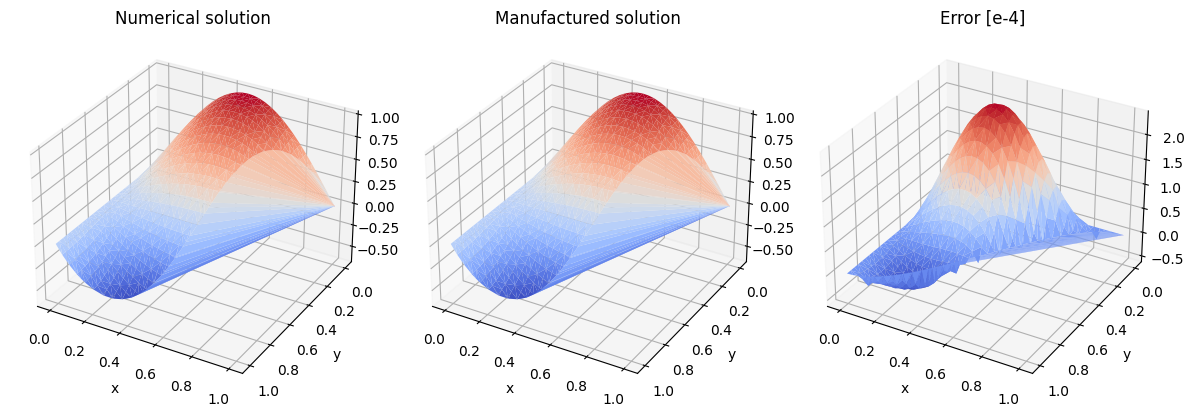

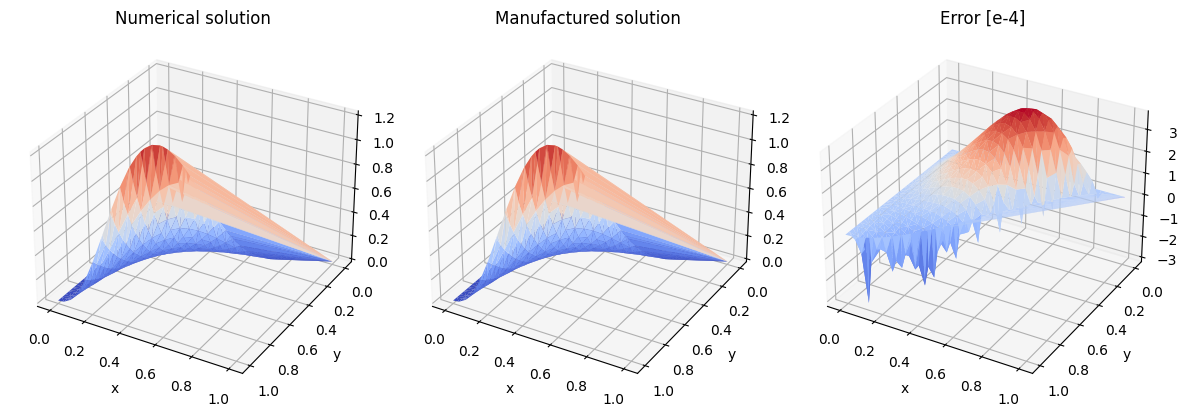

In [ ]:
manufactured_experiment_irregular(T1_irregular, f1_irregular, tool_function=modified_boundary_tools, M=30)
manufactured_experiment_irregular(T2_irregular, f2_irregular, tool_function=modified_boundary_tools, M=30)

### Comparison


In [ ]:
def plot_irregular_boundary_comparison(f_man, T_man, M=30):

    bbvp = BBVP(T_man, f_man)

    # Compute the 3 numerical solution and corresponding analytic solutions
    x1, y1, U1_num = irregular_boundary_solver(bbvp, fattened_boundary_tools, M, remove_external=False)
    U1_anal = T_man(x1,y1)
    x2, y2, U2_num = irregular_boundary_solver(bbvp, fattened_boundary_tools_project, M, remove_external=True)
    U2_anal = T_man(x2,y2)
    x3, y3, U3_num = irregular_boundary_solver(bbvp, modified_boundary_tools, M, remove_external=False)
    U3_anal = T_man(x3,y3)

    x_arrays = [x1, x2, x3]
    y_arrays = [y1, y2, y3]
    U_anal_arrays = [U1_anal, U2_anal, U3_anal]
    U_num_arrays = [U1_num, U2_num, U3_num]
    titles = ["Fattened", "Fattened with projection", "Modified"]

    # Plot solutions and errors
    fig = plt.figure(figsize=(12, 8))
    for i in range(3):

        ax1 = fig.add_subplot(2,3,i+1, projection='3d')
        add_surface(ax1, x_arrays[i], y_arrays[i], U_anal_arrays[i], title=titles[i], invert_x=False)

        ax2 = fig.add_subplot(2,3,i+4, projection='3d')
        error = U_num_arrays[i]-U_anal_arrays[i]
        mag = int(np.log10(np.max(np.abs(error))))-1
        add_surface(ax2, x_arrays[i], y_arrays[i], (error)/10**(mag), title=f"Error [e{mag}]", invert_x=False)

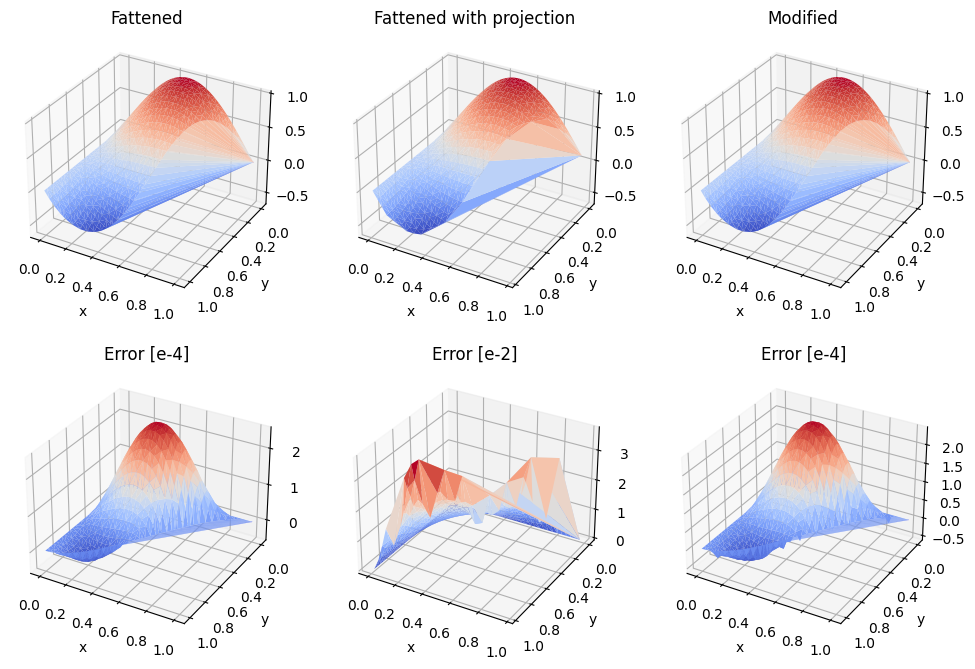

In [ ]:
plot_irregular_boundary_comparison(f1_irregular, T1_irregular)

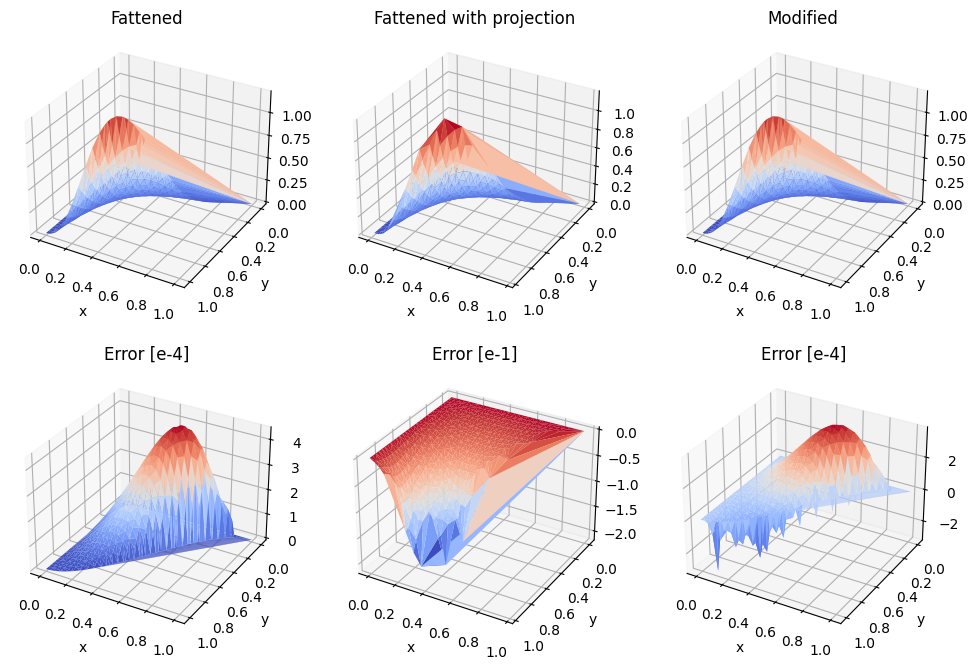

In [ ]:
plot_irregular_boundary_comparison(f2_irregular, T2_irregular)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=42426271-88a7-4adc-ba0e-a178b326bae7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>